# Counties in Colorado

In [40]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import tqdm
from rtree import index

pd.set_option('display.max_columns', None)

In [2]:
import spatialite

with spatialite.connect(':memory:') as db:
    print(db.execute('SELECT spatialite_version()').fetchone()[0])

4.3.0a


## Getting a list of the counties

We can pull the list of Colorado counties of Wikipedia

In [3]:
response = requests.get("https://en.wikipedia.org/wiki/List_of_counties_in_Colorado")
print(response.status_code)
soup = BeautifulSoup(response.text, 'html.parser')

200


In [4]:
table = soup.find('table', {'class': "wikitable sortable"})
body = table.select('tr')
header = body[0]
values = body[1:]

col_names = [th.text.strip().split('[')[0] for th in header.select('th')]
col_names = col_names[:-1]

def parse_table_entry(data):
    county_name = data.select('th')[0].text
    county_name = county_name.replace("City and County of ", "")
    county_name = county_name.replace(" County", "")
    county_name = county_name.strip()
    
    data_vals = [d.text.strip().replace(u'\xa0', u' ') for d in data.select('td')]
    # Get rid of the empty string from failing to parse the map
    data_vals = list(filter(None, data_vals))
    # Only take the value and not the units
    data_vals[-1] = data_vals[-1].split()[0]
    data_vals[-1] = data_vals[-1].replace(',', '')
    data_vals[-2] = data_vals[-2].replace(',', '')
    
    return [county_name] + data_vals
    
data = [parse_table_entry(value) for value in values]
data = list(map(list, zip(*data)))
data = {col: dat for col, dat in zip(col_names, data)}

county_df = pd.DataFrame(data)
county_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64 entries, 0 to 63
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   County       64 non-null     object
 1   FIPS code    64 non-null     object
 2   County seat  64 non-null     object
 3   Est.         64 non-null     object
 4   Formed from  64 non-null     object
 5   Etymology    64 non-null     object
 6   Population   64 non-null     object
 7   Area         64 non-null     object
dtypes: object(8)
memory usage: 4.1+ KB


In [5]:
counties = (county_df.rename(columns=str.lower)
                     .rename(columns={'fips code': 'fips',
                                      'est.': 'established'})
                     .drop(columns=['formed from', 'etymology'])
                     .assign(fips=lambda x: x.fips.str.pad(3, fillchar='0'),
                             established=lambda x: pd.to_datetime(x.established),
                             population=lambda x: pd.to_numeric(x.population),
                             area=lambda x: pd.to_numeric(x.area)))

In [6]:
counties.tail(20)

,county,fips,county seat,established,population,area
44,Morgan,087,Fort Morgan,1889-02-19,28159,1293.83
45,Otero,089,La Junta,1889-03-25,18831,1267.66
46,Ouray,091,Ouray,1877-01-18,4436,542.30
47,Park,093,Fairplay,1861-11-01,16206,2209.36
48,Phillips,095,Holyoke,1889-03-27,4442,688.30
49,Pitkin,097,Aspen,1881-02-23,17148,970.37
50,Prowers,099,Lamar,1889-04-11,12551,1645.37
51,Pueblo,101,Pueblo,1861-11-01,159063,2396.77
52,Rio Blanco,103,Meeker,1889-03-25,6666,3226.24
53,Rio Grande,105,Del Norte,1874-02-10,11982,913.10


# Shapefiles

Big Discovery: https://github.com/mggg-states/CO-shapefiles. What does this look like? Let's find out!
Other resources:
https://github.com/nvkelso/election-geodata

Notes on the mggg states:

"Precincts for certain counties were not included in the shapefile provided by the Demographer's Office and were digitized from maps provided by the county. Those counties are: Boulder, Denver, Douglas, and El Paso. For Las Animas county, the voter file was geocoded and used to identify precinct boundaries. Demographic data were aggregated from the census block level and precincts were assigned to districts using MGGG's proration software."


We have several sources for statefiles for the state of Colorado. Many of the more populous counties maintain an open data portal that can serve current shapefiles for that county. There is the nvkelso repository that has shapefiles from 2012, which may be mislkabelled compared to the electron result data from the Secretary of State's office. Finally, we have the 2018 shapefiles from Todd Bleess of the Colorado State Demographer's Office with cleaning and processing performed by members of Beth Malmskog's team at Colorado College.

The goal is to look at electroal trend from 2010ish leading up to the 2020 election. From these goals there are important questions to answer:
  * How much do the precinct boundaries change election to election? Can we use old shapefiles and accurately capture 90% of the population? 95%? 99%? 
  * Can we reference election results to all of the shapefiles that we have?
  * How well matched are the shapefiles form different sources?
  
The first step is to load in the shapefile data from all of the sources that we have. 

countyfp
voting district
state fp
geoid10
name
geometry

In [7]:
import geopandas as gpd
import matplotlib.pyplot as plt

data_dir = "../data/raw/precincts/"

## 2012 Data

https://github.com/nvkelso/election-geodata

Same as TIGER/Line Shapefile, 2012, 2010 state, Colorado, 2010 Census Voting District State-based (VTD):
https://catalog.data.gov/dataset/tiger-line-shapefile-2012-2010-state-colorado-2010-census-voting-district-state-based-vtd

In [8]:
filename = data_dir + "tl_2012_08_vtd10/"

precincts_2012 = gpd.read_file(filename)
precincts_2012[precincts_2012.COUNTYFP10 == "013"].head(5)

,STATEFP10,COUNTYFP10,VTDST10,GEOID10,VTDI10,NAME10,NAMELSAD10,LSAD10,MTFCC10,FUNCSTAT10,ALAND10,AWATER10,INTPTLAT10,INTPTLON10,geometry
3016,08,013,07066,0801307066,A,Boulder 66,Boulder 66,00,G5240,N,22758922,460044,+40.0087552,-105.0664816,"MULTIPOLYGON (((-105.08257 39.95928, -105.0823..."
3017,08,013,07061,0801307061,A,Boulder 61,Boulder 61,00,G5240,N,5709633,36409,+39.9514814,-105.1329320,"POLYGON ((-105.16071 39.95544, -105.16051 39.9..."
3018,08,013,07051,0801307051,A,Boulder 51,Boulder 51,00,G5240,N,5489340,11918,+39.9697473,-105.0777635,"POLYGON ((-105.10050 39.95826, -105.10051 39.9..."
3019,08,013,07173,0801307173,A,Boulder 173,Boulder 173,00,G5240,N,1763287,84692,+40.0548460,-105.2918190,"POLYGON ((-105.30015 40.04809, -105.30014 40.0..."
3020,08,013,07058,0801307058,A,Boulder 58,Boulder 58,00,G5240,N,792869,11136,+39.9695323,-105.1432151,"POLYGON ((-105.14633 39.97095, -105.14630 39.9..."


In [9]:
precincts_2012.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3250 entries, 0 to 3249
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   STATEFP10   3250 non-null   object  
 1   COUNTYFP10  3250 non-null   object  
 2   VTDST10     3250 non-null   object  
 3   GEOID10     3250 non-null   object  
 4   VTDI10      3250 non-null   object  
 5   NAME10      3250 non-null   object  
 6   NAMELSAD10  3250 non-null   object  
 7   LSAD10      3250 non-null   object  
 8   MTFCC10     3250 non-null   object  
 9   FUNCSTAT10  3250 non-null   object  
 10  ALAND10     3250 non-null   int64   
 11  AWATER10    3250 non-null   int64   
 12  INTPTLAT10  3250 non-null   object  
 13  INTPTLON10  3250 non-null   object  
 14  geometry    3250 non-null   geometry
dtypes: geometry(1), int64(2), object(12)
memory usage: 381.0+ KB


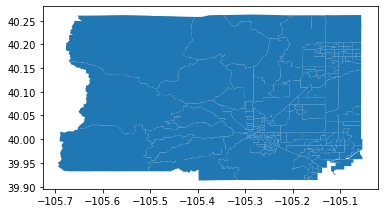

In [10]:
precincts_2012[precincts_2012.COUNTYFP10 == "013"].plot()

## 2016 Data

https://dataverse.harvard.edu/file.xhtml?persistentId=doi:10.7910/DVN/NH5S2I/EBUSFP&version=34.0

In [11]:
filename = data_dir + "co_2016/"

precincts_2016 = gpd.read_file(filename)
precincts_2016.head()

,COUNTYFP,NAMELSAD,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREGSte,G16PREIMcM,G16PREOth,G16USSDBen,G16USSRGle,G16USSLWil,G16USSGMen,G16USSOth,geometry
0,001,Adams 001,708,240,54,23,6,17,655,237,46,19,10,"POLYGON Z ((-105.05325 39.79106 0.00000, -105...."
1,001,Adams 002,776,291,52,17,6,11,730,280,43,22,9,"POLYGON Z ((-105.02521 39.80072 0.00000, -105...."
2,001,Adams 003,646,247,56,21,5,8,625,254,34,15,3,"POLYGON Z ((-105.02500 39.82249 0.00000, -105...."
3,001,Adams 007,545,372,36,15,7,15,525,344,37,13,9,"POLYGON Z ((-105.05321 39.79724 0.00000, -105...."
4,001,Adams 053,471,481,54,10,6,13,491,446,37,8,8,"POLYGON Z ((-105.01553 39.89966 0.00000, -105...."


In [12]:
precincts_2016[precincts_2016.COUNTYFP == '013']

,COUNTYFP,NAMELSAD,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREGSte,G16PREIMcM,G16PREOth,G16USSDBen,G16USSRGle,G16USSLWil,G16USSGMen,G16USSOth,geometry
1967,013,506,322,179,19,4,6,1,309,209,11,5,0,"POLYGON Z ((-105.15054 40.08732 0.00000, -105...."
1968,013,702,153,119,16,5,2,1,149,123,11,8,0,"POLYGON Z ((-105.14987 40.13406 0.00000, -105...."
1969,013,505,548,161,15,20,6,9,509,182,14,33,4,"POLYGON Z ((-105.16274 40.10160 0.00000, -105...."
1970,013,701,298,170,17,6,0,3,293,185,8,15,1,"POLYGON Z ((-105.18322 40.12389 0.00000, -105...."
1971,013,705,292,253,34,12,3,3,293,274,9,18,2,"POLYGON Z ((-105.15905 40.26121 0.00000, -105...."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2195,013,315,517,186,28,7,6,1,486,217,18,12,3,"POLYGON Z ((-105.12788 40.00019 0.00000, -105...."
2196,013,310,830,223,57,26,10,8,818,249,31,37,10,"POLYGON Z ((-105.09328 40.01466 0.00000, -105...."
2197,013,309,706,225,44,22,6,8,685,239,41,30,6,"POLYGON Z ((-105.07447 40.00754 0.00000, -105...."
2198,013,316,672,296,45,14,7,9,628,364,21,18,2,"POLYGON Z ((-105.10254 40.02953 0.00000, -105...."


In [13]:
precincts_2016.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3009 entries, 0 to 3008
Data columns (total 14 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   COUNTYFP    3009 non-null   object  
 1   NAMELSAD    3009 non-null   object  
 2   G16PREDCli  3009 non-null   int64   
 3   G16PRERTru  3009 non-null   int64   
 4   G16PRELJoh  3009 non-null   int64   
 5   G16PREGSte  3009 non-null   int64   
 6   G16PREIMcM  3009 non-null   int64   
 7   G16PREOth   3009 non-null   int64   
 8   G16USSDBen  3009 non-null   int64   
 9   G16USSRGle  3009 non-null   int64   
 10  G16USSLWil  3009 non-null   int64   
 11  G16USSGMen  3009 non-null   int64   
 12  G16USSOth   3009 non-null   int64   
 13  geometry    3009 non-null   geometry
dtypes: geometry(1), int64(11), object(2)
memory usage: 329.2+ KB


## 2018 Data

https://github.com/mggg-states/CO-shapefiles

In [14]:
filename = data_dir + "CO_precincts/"

precincts_2018 = gpd.read_file(filename)
precincts_2018['geometry'] = precincts_2018['geometry'].to_crs(epsg=4269)
print(precincts_2018.geometry.crs)
precincts_2018.head()

{'init': 'epsg:26913'}


,COUNTYFP,VTDST,NAME,CD116FP,SLDUST,SLDLST,PRECID,AG18D,AG18R,SOS18D,SOS18R,TRE18D,TRE18R,GOV18D,GOV18R,REG18D,REG18R,USH18D,USH18R,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,005,005230,Arapahoe 230,01,031,009,1310903230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.90405 39.62544, -104.90392 39.6..."
1,005,005256,Arapahoe 256,06,026,003,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.85246 39.62409, -104.85209 39.6..."
2,005,005359,Arapahoe 359,04,029,056,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.62209 39.69280, -104.62206 39.6..."
3,005,005561,Arapahoe 561,06,028,036,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.75365 39.68200, -104.74693 39.6..."
4,031,031745,Denver 745,01,033,007,1330716745,1084,303,1073,316,1046,334,1137,272,1050,254,1121,264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.86598 39.79032, -104.86638 39.7..."


In [15]:
precincts_2018.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 3135 entries, 0 to 3134
Data columns (total 45 columns):
 #   Column    Non-Null Count  Dtype   
---  ------    --------------  -----   
 0   COUNTYFP  3135 non-null   object  
 1   VTDST     3135 non-null   object  
 2   NAME      3135 non-null   object  
 3   CD116FP   3135 non-null   object  
 4   SLDUST    3135 non-null   object  
 5   SLDLST    3135 non-null   object  
 6   PRECID    3135 non-null   int64   
 7   AG18D     3135 non-null   int64   
 8   AG18R     3135 non-null   int64   
 9   SOS18D    3135 non-null   int64   
 10  SOS18R    3135 non-null   int64   
 11  TRE18D    3135 non-null   int64   
 12  TRE18R    3135 non-null   int64   
 13  GOV18D    3135 non-null   int64   
 14  GOV18R    3135 non-null   int64   
 15  REG18D    3135 non-null   int64   
 16  REG18R    3135 non-null   int64   
 17  USH18D    3135 non-null   int64   
 18  USH18R    3135 non-null   int64   
 19  TOTPOP    3135 non-null   int64   
 20  

In [16]:
precincts_2018[precincts_2018.COUNTYFP == "013"]

,COUNTYFP,VTDST,NAME,CD116FP,SLDUST,SLDLST,PRECID,AG18D,AG18R,SOS18D,SOS18R,TRE18D,TRE18R,GOV18D,GOV18R,REG18D,REG18R,USH18D,USH18R,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
62,013,013400,Boulder 400,02,017,033,2147483647,49,55,53,57,48,58,58,53,49,51,54,49,154,132,2,1,0,0,0,1,15,10,0,0,0,0,5,0,131,13,112,2,1,0,0,0,1,"MULTIPOLYGON (((-105.08235 39.95936, -105.0816..."
92,013,013706,Boulder 706,04,018,011,2147483647,92,61,94,61,87,67,92,57,90,54,98,58,218,195,1,0,1,0,0,3,17,5,0,0,0,0,11,1,176,8,164,1,0,1,0,0,1,"POLYGON ((-105.17825 40.16811, -105.17824 40.1..."
149,013,013902,Boulder 902,02,016,013,2147483647,173,46,174,51,156,62,175,49,160,45,172,42,348,322,1,0,4,0,0,11,9,1,0,1,0,0,5,0,299,7,284,0,0,2,0,0,4,"POLYGON ((-105.69435 39.95015, -105.69366 39.9..."
154,013,013905,Boulder 905,02,018,013,2147483647,173,63,182,59,172,58,182,61,171,52,177,51,353,331,0,2,1,0,0,1,16,14,0,0,0,0,1,0,277,11,260,0,2,1,0,0,1,"POLYGON ((-105.45058 39.94881, -105.45044 39.9..."
174,013,013702,Boulder 702,02,018,011,2147483647,177,130,166,145,163,141,178,130,166,134,168,131,387,348,0,1,4,0,0,2,30,12,0,0,0,0,14,4,287,18,261,0,1,4,0,0,2,"POLYGON ((-105.18328 40.12739, -105.18326 40.1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2883,013,013849,Boulder 849,02,018,010,2147483647,370,58,371,57,352,75,384,50,367,49,358,48,2736,2103,45,1,238,0,6,93,243,170,0,3,2,0,40,22,2707,238,2079,45,1,238,0,6,93,"POLYGON ((-105.25949 40.00031, -105.25833 40.0..."
2906,013,013834,Boulder 834,02,018,010,2147483647,444,101,426,135,427,132,470,91,437,100,414,102,2820,2382,44,7,117,2,1,92,169,112,0,1,1,0,37,12,2809,169,2372,44,7,117,2,1,91,"POLYGON ((-105.26976 40.00598, -105.26967 40.0..."
2927,013,013301,Boulder 301,02,017,012,2147483647,1056,244,1052,256,1013,279,1076,231,1015,226,1039,217,2874,1123,8,15,86,2,8,48,1582,833,8,40,3,0,616,79,1975,966,895,8,13,63,1,2,25,"POLYGON ((-105.09053 39.98688, -105.08811 39.9..."
2937,013,013610,Boulder 610,04,017,012,2147483647,847,312,868,302,823,329,875,291,816,289,897,313,2905,1592,24,7,29,0,15,52,1184,615,2,41,5,1,466,53,1981,665,1233,21,6,25,0,9,20,"POLYGON ((-105.10255 40.15374, -105.10255 40.1..."


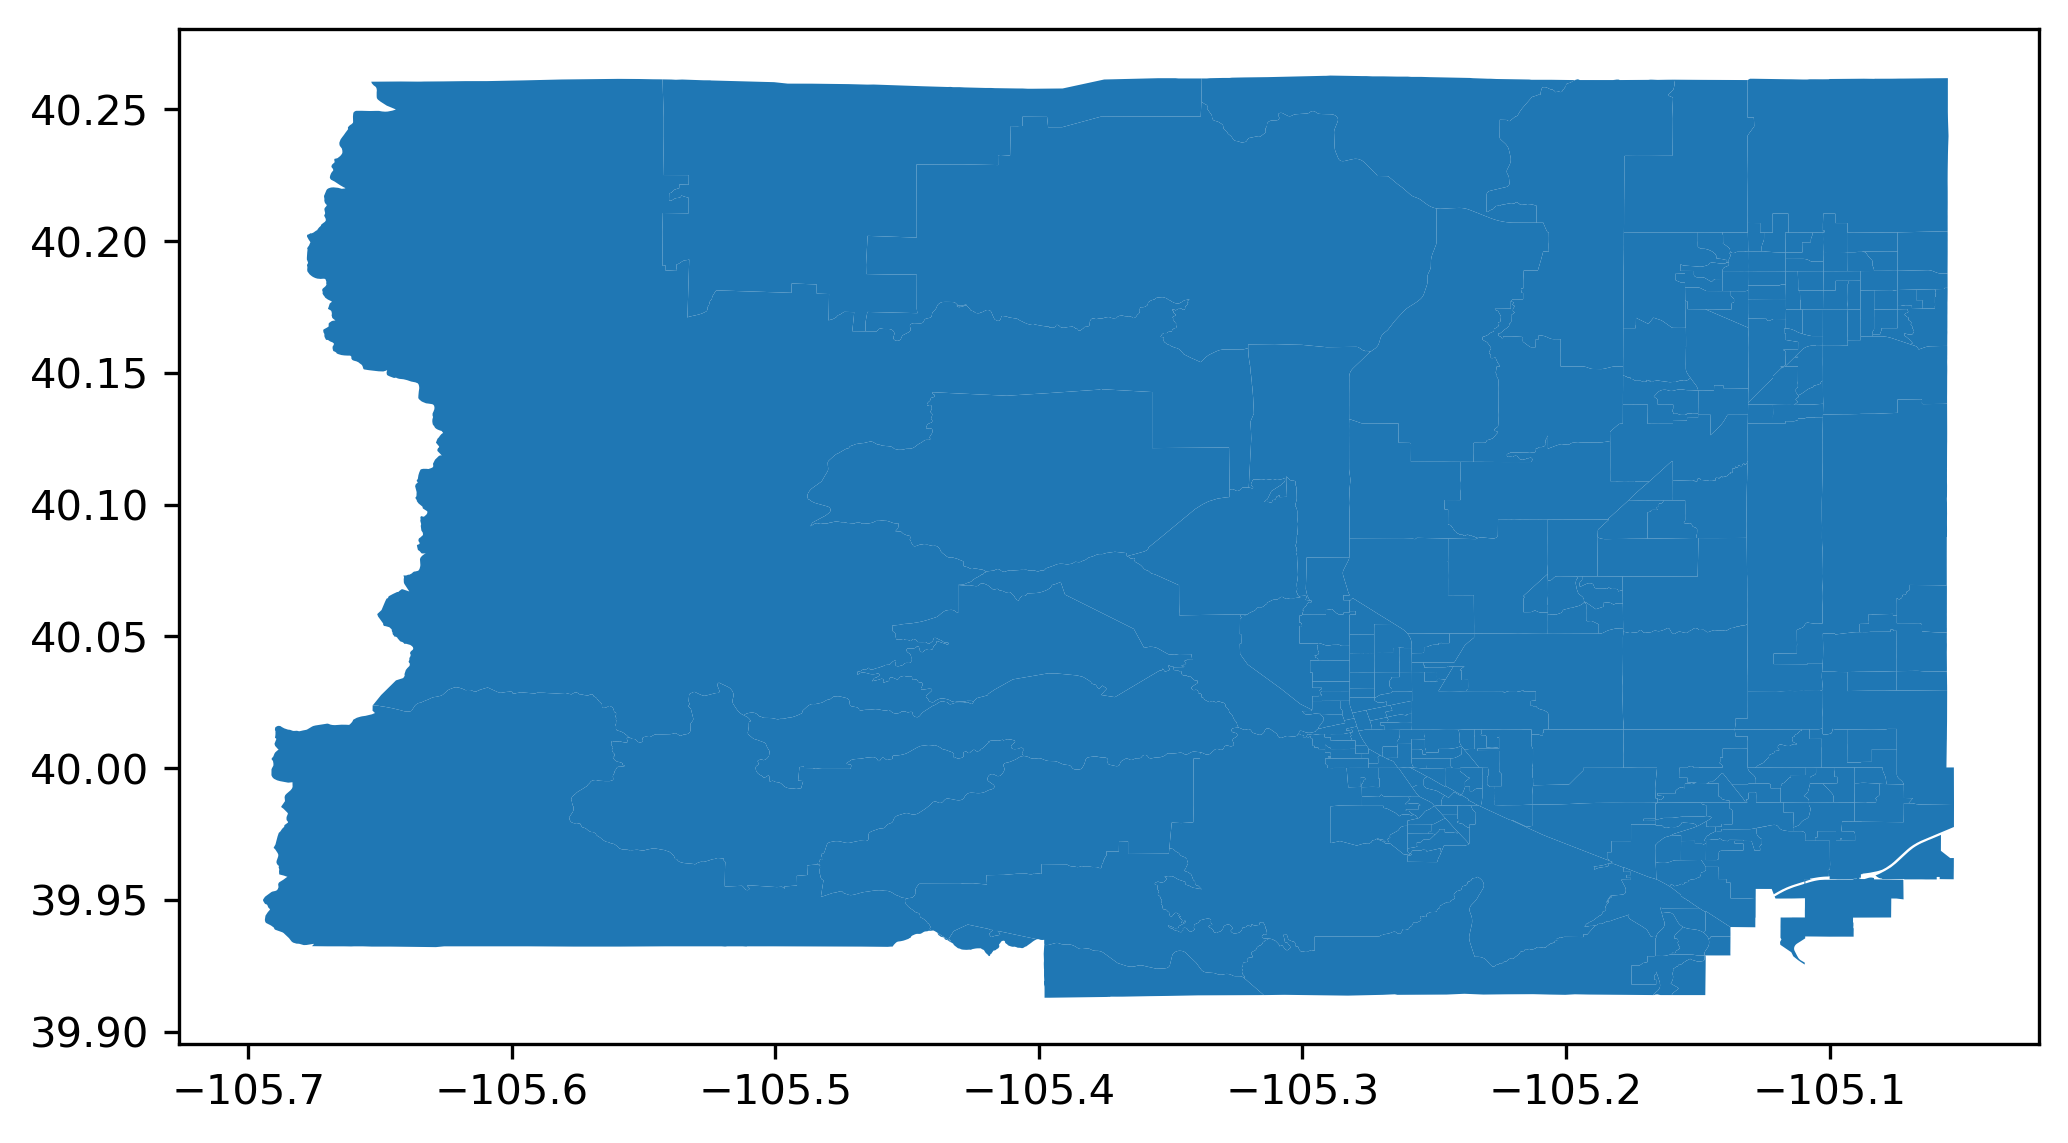

In [17]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8), dpi=300)

precincts_2018[precincts_2018.COUNTYFP == "013"].plot(ax=ax)

## What is up with the 2012 Dataset?

The 2012 data set does not seem to have too much in common with the 2016 or 2018 shapefiles, and most importantly, *does not have a proper precint label*. Without a label for what rpecinct each shape is, I don't know how to tie voting results or voter registration data back to the precinct. This makes the precinct shapes pretty useless.

How many precincts are there in Boulder?

In [18]:
bo_2012 = precincts_2012[precincts_2012.COUNTYFP10 == "013"]
boulder_precints_shapefiles_2012 = np.array(list(set([
    str(s)[2:] for s in bo_2012.VTDST10
])))
len(boulder_precints_shapefiles_2012)

234

In [19]:
filename = "../data/raw/results/2012GeneralPrecinctResults.xlsx"
boulder_precints_results_2012 = list(set(pd.read_excel(filename).Precinct.values))
boulder_precints_results_2012 = [str(x)[-3:] for x in boulder_precints_results_2012]
no = []
for res in boulder_precints_results_2012:
    if res not in boulder_precints_shapefiles_2012:
        no.append(res)

In [20]:
len(no)

1161

Instead of looking at the overlap in precinct numbers, we can just look at the overlap of the precinct shapefiles themselves. This is a rather tedious calculation, and I have not optimized it with any clever spatial indexing, so it takes a while to run.

In [269]:
boulder_2012 = precincts_2012[precincts_2012.COUNTYFP10 == "013"]
boulder_2018 = precincts_2018[precincts_2018.COUNTYFP == "013"]
overlap = np.zeros((len(boulder_2012), len(boulder_2018)))

for i, shape1 in enumerate(boulder_2012.geometry):
    for j, shape2 in enumerate(boulder_2018.geometry):
        overlap[i,j] = (2 * shape1.intersection(shape2).area / 
                       (shape1.area + shape2.area))

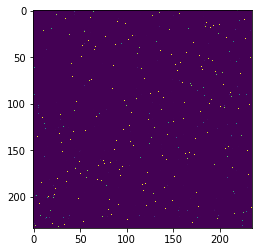

In [274]:
plt.imshow(overlap)
plt.show()

Instead of looking at a large, mostly empty matrix, we can devise a (maybe?) better metric to judge by. We don't expect the overlap between even two identical rpecincts to be the same due to float errors in matching up the boundaries, but the fraction of overlap should be high, like `0.99` high or something. For the matrix of overlaps above, we can select from each row the number of entries that are greater than this threshold. 

For identical shapes, we would expect to have one entry with a very high value, and several with smaller values. Therefore, the number of overlaps above the threshold per row should be one. As we reduce the threshold towards zero, the number of overlaps per row should stay at one, until we get to small values like `0.01` or so. Then there should start to be an increase in the number of cells with an overlap greater than the threshold. If we plot the number of rows that have more than one match at a given threshold against threshold, we would expect to see a flat line at zero for perfectly matching precincts.

In [51]:
def df_to_rtree_index(df):
    idx = index.Index()
    for _, row in df.bounds.iterrows():
        idx.insert(row.name, (row.minx, row.miny, row.maxx, row.maxy))
    return idx

def overlaps(shapes1, shapes2):
    overlap = np.zeros((len(shapes1), len(shapes2)))
    
    idx1 = df_to_rtree_index(shapes1)
    
    for j, b in tqdm.tqdm(shapes2.bounds.iterrows()):
        shape2 = shapes2.iloc[j]
        bounding_box = (b.minx, b.miny, b.maxx, b.maxy)
        possible = list(idx1.intersection(bounding_box))
        for i, shape1 in shapes1.iloc[possible].iterrows():
            try:
                overlap[i,j] = (2 * shape1.intersection(shape2).area / 
                               (shape1.area + shape2.area))
            except:
                pass
        
    return overlap 

def calc_thresh_overlaps(overlap):
    zero_above = []
    more_than_one_above = []
    for frac in np.linspace(.001, .9, 100):
        above_overlap = []
        for row in overlap:
            above_overlap.append(len(row[row>frac]))
        zero_above.append(len([num for num in above_overlap if num == 0]))
        more_than_one_above.append(len([num for num in above_overlap if num > 1]))
    
    return zero_above, more_than_one_above

In [52]:
overlap = overlaps(precincts_2012, precincts_2012)

3250it [00:05, 560.42it/s]


In [53]:
def plot_overlaps(zero_above, more_than_one_above):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4), dpi=150)

    ax[0].plot(np.linspace(.001, .9, 100), zero_above)
    ax[0].set_title('Zero overlaps above threshold')

    ax[1].plot(np.linspace(.001, .9, 100), more_than_one_above)
    ax[1].set_title('More than one overlap above threshold')

    for a in ax:
        a.set_xlabel('Overlap threshold')
        a.set_ylabel('Number of precincts')
    plt.tight_layout()
    plt.show()

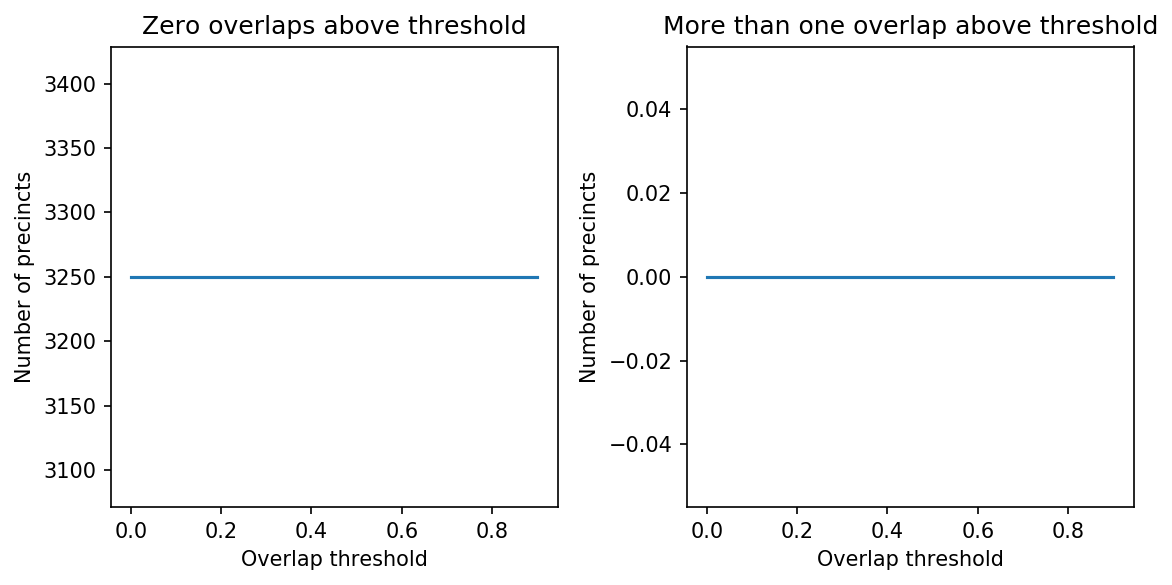

In [54]:
zero_above_self, more_than_one_above_self = calc_thresh_overlaps(overlap)
plot_overlaps(zero_above_self, more_than_one_above_self)

For non-identical shapes, we should see that at high threshold values, there are a large number of shapes that have no match, because they are split over too many smaller shapes. As the threshold is decreased, fewer shapes will have zero matches, but some will start to have many matches.

In [300]:
zero_above_1216, more_than_one_above_1216 = overlaps(precincts_2012, precincts_2016)

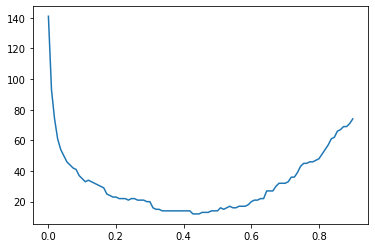

In [301]:
plot_overlaps(zero_above_1216, more_than_one_above_1216)

In [303]:
zero_above_1218, more_than_one_above_1218 = overlaps(precincts_2012, precincts_2018)

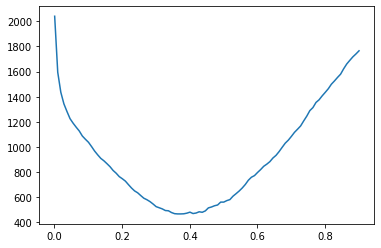

In [304]:
plot_overlaps(zero_above_1218, more_than_one_above_1218)

In [333]:
zero_above_1618, more_than_one_above_1618 = overlaps(precincts_2016, precincts_2018)

TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -105.01008461999999 39.629139302000056 0 at -105.01008461999999 39.629139302000056 0
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -105.01008461999999 39.629139302000056 0 at -105.01008461999999 39.629139302000056 0
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -105.01008461999999 39.629139302000056 0 at -105.01008461999999 39.629139302000056 0
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -105.01008461999999 39.629139302000056 0 at -105.01008461999999 39.629139302000056 0
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -105.01008461999999 39.629139302000056 0 at -105.01008461999999 39.629139302000056 0
TopologyException: Input geom 0 is invalid: Ring Self-intersection at or near point -105.01008461999999 39.629139302000056 0 at -105.01008461999999 39.6291

In [ ]:
plot_overlaps(zero_above_1618, more_than_one_above_1618)

In [334]:
names = ['2012 w/ 2012', '2016 w/ 2018', '2012 w/ 2016', '2012 w/ 2018']
zeros = [zero_above_self, zero_above_1618, zero_above_1216, zero_above_1218]
more = [more_than_one_above_self, more_than_one_above_1618,
        more_than_one_above_1216, more_than_one_above_1218]

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(4, 8), dpi=150)

x = np.linspace(.001, .9, 100)

for z, name in zip(zeros, names):
    ax[0].plot(x, z, label=name)
    
for m, name in zip(more, names):
    ax[1].plot(x, m, label=name)
    
ax[0].set_title('Zero overlaps above threshold')
ax[1].set_title('More than one overlap above threshold')

for a in ax:
    a.set_xlabel('Overlap threshold')
    a.set_ylabel('Number of precincts')
plt.show()

## Conclusion

The 2012 data is no good. I can't match any election results to it, and I beleive the precincts from the census data are different to the voting precincts as defined by Colorado. I'll have to stick to the 2016 and 2018 precinct data.

# Cleaning, relabelling and saving

In [22]:
precincts_2016[1:-1:100]

,COUNTYFP,NAMELSAD,G16PREDCli,G16PRERTru,G16PRELJoh,G16PREGSte,G16PREIMcM,G16PREOth,G16USSDBen,G16USSRGle,G16USSLWil,G16USSGMen,G16USSOth,geometry
1,001,Adams 002,776,291,52,17,6,11,730,280,43,22,9,"POLYGON Z ((-105.02521 39.80072 0.00000, -105...."
101,001,Adams 159,435,523,59,10,16,14,434,547,36,5,9,"POLYGON Z ((-104.94027 39.94310 0.00000, -104...."
201,001,Adams 207,267,247,42,9,2,8,292,225,19,4,4,"POLYGON Z ((-104.87847 39.88557 0.00000, -104...."
301,014,Broomfield 028,202,185,17,7,0,10,212,161,21,8,3,"POLYGON Z ((-105.02431 39.93018 0.00000, -105...."
401,031,Denver 402,985,217,59,26,5,13,917,234,49,45,12,"POLYGON Z ((-105.04394 39.78381 0.00000, -105...."
501,031,Denver 417,735,112,48,12,10,5,700,148,21,17,6,"POLYGON Z ((-105.02529 39.76809 0.00000, -105...."
601,031,Denver 743,686,118,43,2,9,3,660,165,21,3,0,"POLYGON Z ((-104.88749 39.76749 0.00000, -104...."
701,031,Denver 924,637,149,53,28,9,7,631,167,50,29,5,"POLYGON Z ((-104.87726 39.65305 0.00000, -104...."
801,043,Fremont 020,209,746,42,10,14,17,313,671,22,11,25,"POLYGON Z ((-105.22734 38.45530 0.00000, -105...."
901,059,Jefferson 056,446,417,45,1,12,5,431,462,24,7,5,"POLYGON Z ((-105.35812 39.69231 0.00000, -105...."


In [23]:
precincts_2018.head()

,COUNTYFP,VTDST,NAME,CD116FP,SLDUST,SLDLST,PRECID,AG18D,AG18R,SOS18D,...,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,005,005230,Arapahoe 230,01,031,009,1310903230,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.90405 39.62544, -104.90392 39.6..."
1,005,005256,Arapahoe 256,06,026,003,2147483647,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.85246 39.62409, -104.85209 39.6..."
2,005,005359,Arapahoe 359,04,029,056,2147483647,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.62209 39.69280, -104.62206 39.6..."
3,005,005561,Arapahoe 561,06,028,036,2147483647,0,0,0,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.75365 39.68200, -104.74693 39.6..."
4,031,031745,Denver 745,01,033,007,1330716745,1084,303,1073,...,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.86598 39.79032, -104.86638 39.7..."


There is very little identifying information for the 2016 data set. The important values are the COUNTY FP, and the number that is part of NAMELSAD. We can add on a coulumn for the name of the county. We can use maup to assign districts to the precincts in 2016. 

For the 2018 data, We will keep all of the identifying information, but cut all the demographic and election result information, as it seems to be rather incomplete. We can recreate this data ourselves using MAUP. 

At the end of the day, we want both data sets to have columns:

COUNTYFP, COUNTYNAME, VTDST3, VTDSTLONG, CD116FP, SLDUST, SLDLST, geometry

In [24]:
def parse_NAMELSAD(value):
    county = None
    vtr_dst = None
    full_vtr_dst = None
    
    try:
        full_vtr_dst = int(value)
    except ValueError:
        full_vtr_dst = int(value.split()[-1])
        county = ' '.join(value.split()[:-1])
        
    vtr_dst = full_vtr_dst % 1000
    vtr_dst = str(vtr_dst).zfill(3)
    
    return (county, vtr_dst, full_vtr_dst)

def lookup_countyfips(fips, counties):
    val = counties[counties["FIPS code"] == int(fips)].County.values
    return val[0]
    

In [25]:
parsed = [parse_NAMELSAD(value) for value in precincts_2016.NAMELSAD.values]
parsed = list(map(list, zip(*parsed)))

In [26]:
def buffer_if_invalid(geom):
    if not geom.is_valid:
        geom = geom.buffer(0)
    return geom

precincts_2016_clean = gpd.GeoDataFrame()
precincts_2016_clean["COUNTYFP"] = precincts_2016["COUNTYFP"].values
precincts_2016_clean["COUNTYNAME"] = [lookup_countyfips(fips, county_df)
                                     for fips in precincts_2016["COUNTYFP"].values]
precincts_2016_clean["COUNTYNUM"] = [None] * len(parsed[1])
precincts_2016_clean["VTDST3"] = parsed[1]
precincts_2016_clean["VTDST5"] = parsed[1]
precincts_2016_clean["VTDSTLONG"] = parsed[2]
precincts_2016_clean["CD115FP"] = [None] * len(parsed[1])
precincts_2016_clean["SLDUST"] = [None] * len(parsed[1])
precincts_2016_clean["SLDLST"] = [None] * len(parsed[1])
precincts_2016_clean['geometry'] = precincts_2016['geometry'].map(buffer_if_invalid)
precincts_2016_clean = precincts_2016_clean.sort_values(by=['COUNTYFP', 'VTDST3'],
                                        ignore_index=True)
precincts_2016_clean.crs = {'init': 'epsg:4269'}

In [27]:
precincts_2016_clean

,COUNTYFP,COUNTYNAME,COUNTYNUM,VTDST3,VTDST5,VTDSTLONG,CD115FP,SLDUST,SLDLST,geometry
0,001,Adams,None,001,001,1,None,None,None,"POLYGON Z ((-105.05325 39.79106 0.00000, -105...."
1,001,Adams,None,002,002,2,None,None,None,"POLYGON Z ((-105.02521 39.80072 0.00000, -105...."
2,001,Adams,None,003,003,3,None,None,None,"POLYGON Z ((-105.02500 39.82249 0.00000, -105...."
3,001,Adams,None,004,004,4,None,None,None,"POLYGON Z ((-105.00625 39.82181 0.00000, -105...."
4,001,Adams,None,005,005,5,None,None,None,"POLYGON Z ((-105.01583 39.82278 0.00000, -105...."
...,...,...,...,...,...,...,...,...,...,...
3004,125,Yuma,None,010,010,10,None,None,None,"POLYGON Z ((-102.80272 39.59127 0.00000, -102...."
3005,125,Yuma,None,011,011,11,None,None,None,"POLYGON Z ((-102.72532 40.11491 0.00000, -102...."
3006,125,Yuma,None,012,012,12,None,None,None,"POLYGON Z ((-102.45291 40.14375 0.00000, -102...."
3007,125,Yuma,None,013,013,13,None,None,None,"POLYGON Z ((-102.79420 40.15202 0.00000, -102...."


In [28]:
parsed = [parse_NAMELSAD(value) for value in precincts_2018.NAME.values]
parsed = list(map(list, zip(*parsed)))

In [29]:
precincts_2018_clean = gpd.GeoDataFrame()
precincts_2018_clean["COUNTYFP"] = precincts_2018["COUNTYFP"].values
precincts_2018_clean["COUNTYNAME"] = [lookup_countyfips(fips, county_df)
                                     for fips in precincts_2018["COUNTYFP"].values]
precincts_2018_clean["COUNTYNUM"] = [None] * len(parsed[1])
precincts_2018_clean["VTDST3"] = precincts_2018["VTDST"].values.astype(int)%1000
precincts_2018_clean["VTDST3"] = precincts_2018_clean["VTDST3"].map(lambda x: str(x).zfill(3))
precincts_2018_clean["VTDST5"] = [None] * len(parsed[1])
precincts_2018_clean["VTDSTLONG"] = precincts_2018["PRECID"]
precincts_2018_clean["CD115FP"] = [None] * len(parsed[1])
precincts_2018_clean["SLDUST"] = [None] * len(parsed[1])
precincts_2018_clean["SLDLST"] = [None] * len(parsed[1])
precincts_2018_clean['geometry'] = precincts_2018['geometry']
precincts_2018_clean = precincts_2018_clean.sort_values(by=['COUNTYFP', 'VTDST3'],
                                                       ignore_index=True)
precincts_2018_clean.crs = {'init': 'epsg:4269'}

In [30]:
precincts_2018_clean

,COUNTYFP,COUNTYNAME,COUNTYNUM,VTDST3,VTDST5,VTDSTLONG,CD115FP,SLDUST,SLDLST,geometry
0,001,Adams,None,001,None,2147483647,None,None,None,"POLYGON ((-105.05325 39.79106, -105.05322 39.7..."
1,001,Adams,None,002,None,2147483647,None,None,None,"POLYGON ((-105.02521 39.80072, -105.02452 39.8..."
2,001,Adams,None,003,None,2147483647,None,None,None,"POLYGON ((-105.02500 39.82249, -105.02499 39.8..."
3,001,Adams,None,004,None,2147483647,None,None,None,"POLYGON ((-105.00625 39.82181, -105.00625 39.8..."
4,001,Adams,None,005,None,2147483647,None,None,None,"POLYGON ((-105.01583 39.82278, -105.01578 39.8..."
...,...,...,...,...,...,...,...,...,...,...
3130,125,Yuma,None,010,None,2147483647,None,None,None,"POLYGON ((-102.80272 39.59127, -102.80272 39.5..."
3131,125,Yuma,None,011,None,2147483647,None,None,None,"POLYGON ((-102.72532 40.11491, -102.72531 40.1..."
3132,125,Yuma,None,012,None,2147483647,None,None,None,"POLYGON ((-102.45291 40.14375, -102.45266 40.2..."
3133,125,Yuma,None,013,None,2147483647,None,None,None,"POLYGON ((-102.79420 40.15202, -102.79418 40.1..."


# Assigning Precinct to districts with maup 

In [31]:
import maup

In [32]:
path = "../data/raw/state/"
state_senate = gpd.read_file(path + "state_senate_districts/").to_crs(epsg=4269)
state_senate['geometry'] = state_senate['geometry'].map(buffer_if_invalid)
state_senate['DISTRICT'] = state_senate['DISTRICT'].map(lambda x: str(x).zfill(2))

state_house = gpd.read_file(path + "state_house_districts/").to_crs(epsg=4269)
state_house['geometry'] = state_house['geometry'].map(buffer_if_invalid)
state_house['DISTRICT'] = state_house['DISTRICT'].map(lambda x: str(x).zfill(2))

federal_house = gpd.read_file(path + "tl_2016_us_cd115/").to_crs(epsg=4269)

In [33]:
state_senate.crs = {'init': state_senate.crs['init']}
state_senate

,DISTRICT,REP,PARTY,geometry
0,08,Randy L Baumgardner,R,"POLYGON ((-108.52614 40.99959, -108.52603 40.9..."
1,25,Kevin Priola,R,"POLYGON ((-103.70570 40.00137, -103.70583 39.9..."
2,24,Beth Martinez Humenik,R,"POLYGON ((-104.99717 39.97384, -104.99715 39.9..."
3,05,Kerry Donovan,D,"POLYGON ((-106.59019 39.92501, -106.57968 39.9..."
4,29,Rhonda Fields,D,"POLYGON ((-104.67261 39.66728, -104.67236 39.6..."
5,15,Kevin Lundberg,R,"POLYGON ((-106.12926 40.99733, -106.12830 40.9..."
6,18,Stephen Fenberg,D,"POLYGON ((-105.28922 40.26278, -105.27746 40.2..."
7,35,Larry W Crowder,R,"POLYGON ((-102.04508 38.61517, -102.04511 38.6..."
8,13,John Cooke,R,"POLYGON ((-104.69679 40.48098, -104.69601 40.4..."
9,31,Lois Court,D,"POLYGON ((-104.94211 39.74014, -104.94187 39.7..."


In [34]:
state_house.crs = {'init': state_house.crs['init']}
state_house

,DISTRICT,REP,PARTY,geometry
0,41,Jovan Melton,D,"POLYGON ((-104.89818 39.69073, -104.89882 39.6..."
1,09,Paul Rosenthal,D,"POLYGON ((-104.92929 39.70853, -104.92898 39.7..."
2,15,Dave Williams,R,"POLYGON ((-104.69881 38.95185, -104.69873 38.9..."
3,26,Diane E Mitsch Bush,D,"POLYGON ((-107.24108 41.00280, -107.24075 41.0..."
4,29,Tracy Kraft-Tharp,D,"POLYGON ((-105.05780 39.91385, -105.05780 39.9..."
...,...,...,...,...
60,49,Perry L Buck,R,"POLYGON ((-106.12926 40.99733, -106.12830 40.9..."
61,59,Barbara Hall McLachlan,D,"POLYGON ((-107.25433 38.73890, -107.25405 38.7..."
62,05,Crisanta Duran,D,"POLYGON ((-104.97102 39.79831, -104.96873 39.7..."
63,03,Jeff Bridges,D,"POLYGON ((-105.01570 39.67868, -105.01340 39.6..."


In [35]:
co_fed_house = federal_house[federal_house.STATEFP == '08']
co_fed_house

,STATEFP,CD115FP,GEOID,NAMELSAD,LSAD,CDSESSN,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
11,08,01,0801,Congressional District 1,C2,115,G5200,N,491985332,7057884,+39.7322859,-104.9087582,"POLYGON ((-105.14597 39.57742, -105.14560 39.5..."
54,08,02,0802,Congressional District 2,C2,115,G5200,N,19517291933,235607941,+40.1370840,-105.7090836,"POLYGON ((-106.65296 40.36469, -106.65292 40.3..."
97,08,03,0803,Congressional District 3,C2,115,G5200,N,128801079777,388429480,+38.7432544,-107.3448493,"POLYGON ((-109.06020 38.27824, -109.06015 38.2..."
135,08,04,0804,Congressional District 4,C2,115,G5200,N,98686746414,435709485,+39.0706831,-103.4138530,"POLYGON ((-105.32922 39.12969, -105.32915 39.1..."
169,08,05,0805,Congressional District 5,C2,115,G5200,N,18818274962,61255623,+38.8154076,-105.3441513,"POLYGON ((-106.59903 39.03627, -106.59894 39.0..."
198,08,06,0806,Congressional District 6,C2,115,G5200,N,1227582196,22111653,+39.7550881,-104.7653511,"POLYGON ((-105.05421 39.57073, -105.05420 39.5..."
224,08,07,0807,Congressional District 7,C2,115,G5200,N,886383176,24940804,+39.8261495,-105.0422236,"POLYGON ((-105.34711 39.90601, -105.34677 39.9..."


In [36]:
def get_assigned_values(source, target, var):
    return target.loc[maup.assign(source, target)][var].values

In [37]:
precincts_2016_clean['CD115FP'] = get_assigned_values(precincts_2016_clean, co_fed_house, 'CD115FP')
precincts_2016_clean['CD115FP'] = precincts_2016_clean['CD115FP'].map(lambda x: x.strip('0'))
precincts_2016_clean['SLDUST'] = get_assigned_values(precincts_2016_clean, state_senate, 'DISTRICT')
precincts_2016_clean['SLDLST'] = get_assigned_values(precincts_2016_clean, state_house, 'DISTRICT')

precincts_2018_clean['CD115FP'] = get_assigned_values(precincts_2018_clean, co_fed_house, 'CD115FP')
precincts_2018_clean['CD115FP'] = precincts_2018_clean['CD115FP'].map(lambda x: x.strip('0'))
precincts_2018_clean['SLDUST'] = get_assigned_values(precincts_2018_clean, state_senate, 'DISTRICT')
precincts_2018_clean['SLDLST'] = get_assigned_values(precincts_2018_clean, state_house, 'DISTRICT')

In [38]:
precincts_2018_clean[1::100]

,COUNTYFP,COUNTYNAME,COUNTYNUM,VTDST3,VTDST5,VTDSTLONG,CD115FP,SLDUST,SLDLST,geometry
1,001,Adams,None,002,None,2147483647,7,21,32,"POLYGON ((-105.02521 39.80072, -105.02452 39.8..."
101,001,Adams,None,102,None,2147483647,7,24,34,"POLYGON ((-104.97778 39.88515, -104.97779 39.8..."
201,001,Adams,None,202,None,2147483647,7,21,30,"POLYGON ((-104.80899 39.91088, -104.80898 39.9..."
301,005,Arapahoe,None,139,None,1310903139,1,31,09,"MULTIPOLYGON (((-104.93024 39.67483, -104.9286..."
401,005,Arapahoe,None,242,None,2147483647,6,27,37,"POLYGON ((-104.89515 39.57076, -104.89133 39.5..."
501,005,Arapahoe,None,356,None,2147483647,6,29,56,"POLYGON ((-104.70701 39.56746, -104.70700 39.5..."
601,005,Arapahoe,None,501,None,1310903501,1,31,09,"POLYGON ((-104.94074 39.70634, -104.94073 39.7..."
701,013,Boulder,None,209,None,2147483647,2,17,12,"POLYGON ((-105.17055 39.98077, -105.16605 39.9..."
801,013,Boulder,None,653,None,2147483647,4,17,11,"POLYGON ((-105.14057 40.20328, -105.14054 40.2..."
901,013,Boulder,None,900,None,2147483647,2,16,13,"POLYGON ((-105.32296 39.92424, -105.32291 39.9..."


## Recreate long Precinct Number

In [39]:
data_dir = "../data/raw/results/"
results_2018 = pd.read_excel(data_dir + str(2018) + "GeneralPrecinctResults.xlsx")
county_nums = results_2018.Precinct.map(lambda x: str(x)[-5:-3]).values
county_names = results_2018.County.values
mapping = sorted(list(set(zip(county_nums, county_names))))
mapping = {county: num for (num, county) in mapping}

In [40]:
precincts_2016_clean['COUNTYNUM'] = precincts_2016_clean.COUNTYNAME.map(lambda x: mapping[x])
precincts_2018_clean['COUNTYNUM'] = precincts_2018_clean.COUNTYNAME.map(lambda x: mapping[x])

In [41]:
precincts_2016_clean

,COUNTYFP,COUNTYNAME,COUNTYNUM,VTDST3,VTDST5,VTDSTLONG,CD115FP,SLDUST,SLDLST,geometry
0,001,Adams,01,001,001,1,7,21,32,"POLYGON Z ((-105.05325 39.79106 0.00000, -105...."
1,001,Adams,01,002,002,2,7,21,32,"POLYGON Z ((-105.02521 39.80072 0.00000, -105...."
2,001,Adams,01,003,003,3,7,21,32,"POLYGON Z ((-105.02500 39.82249 0.00000, -105...."
3,001,Adams,01,004,004,4,7,21,32,"POLYGON Z ((-105.00625 39.82181 0.00000, -105...."
4,001,Adams,01,005,005,5,7,21,32,"POLYGON Z ((-105.01583 39.82278 0.00000, -105...."
...,...,...,...,...,...,...,...,...,...,...
3004,125,Yuma,63,010,010,10,4,01,65,"POLYGON Z ((-102.80272 39.59127 0.00000, -102...."
3005,125,Yuma,63,011,011,11,4,01,65,"POLYGON Z ((-102.72532 40.11491 0.00000, -102...."
3006,125,Yuma,63,012,012,12,4,01,65,"POLYGON Z ((-102.45291 40.14375 0.00000, -102...."
3007,125,Yuma,63,013,013,13,4,01,65,"POLYGON Z ((-102.79420 40.15202 0.00000, -102...."


1-5-101.5. Precinct numbering.

(1) There is hereby created a precinct numbering system that shall be used by the county clerk and recorder of each county of the state in numbering election precincts established in accordance with section 1-5-101. The precinct numbering system created pursuant to this section shall not be used until the reapportionment of senatorial and representative districts required to be conducted after the 2000 federal census pursuant to section 48 of article V of the Colorado constitution is completed, but the precinct numbering system shall be implemented by each county clerk and recorder no later than July 1, 2002.

(2) Any election precinct established pursuant to the provisions of section 1-5-101 shall be numbered with a ten digit number as follows:

(a) The first digit of the precinct number shall consist of the number of the congressional district in which the precinct is contained.

(b) The second and third digits of the precinct number shall consist of the number of the state senatorial district in which the precinct is contained. If the state senatorial district consists of one digit, such digit shall be preceded by a zero for purposes of the precinct number.

(c) The fourth and fifth digits of the precinct number shall consist of the number of the state representative district in which the precinct is contained. If the state representative district consists of one digit, such digit shall be preceded by a zero for purposes of the precinct number.

(c.5) The sixth and seventh digits of the precinct number shall consist of the number assigned by the secretary of state to represent the county in which the precinct is contained.

(d) The last three digits of the precinct number shall consist of an individual precinct number as determined by the county clerk and recorder.

(3) Any changes in election precinct numbering required pursuant to this section shall be completed and reported by the county clerk and recorder to the secretary of state in accordance with section 1-5-103 (3).

https://www.sos.state.co.us/pubs/info_center/laws/Title1/Title1Article5.html

In [42]:
def generate_long_precinct_number(df):
    congress = df.CD115FP.values
    state_senate = df.SLDUST.values
    state_rep = df.SLDLST.values
    county = df.COUNTYNUM.values
    precinct = df.VTDST3.values
    long = []
    for (a, b, c, d, e) in zip(congress, state_senate, state_rep, county, precinct):
        long.append(a+b+c+d+e)
    return long

In [43]:
precincts_2016_clean['VTDSTLONG'] = generate_long_precinct_number(precincts_2016_clean)
precincts_2018_clean['VTDSTLONG'] = generate_long_precinct_number(precincts_2018_clean)

precincts_2016_clean['VTDST5'] = precincts_2016_clean['VTDSTLONG'].map(lambda x: x[-5:])
precincts_2018_clean['VTDST5'] = precincts_2018_clean['VTDSTLONG'].map(lambda x: x[-5:])

In [44]:
precincts_2018_clean

,COUNTYFP,COUNTYNAME,COUNTYNUM,VTDST3,VTDST5,VTDSTLONG,CD115FP,SLDUST,SLDLST,geometry
0,001,Adams,01,001,01001,7213201001,7,21,32,"POLYGON ((-105.05325 39.79106, -105.05322 39.7..."
1,001,Adams,01,002,01002,7213201002,7,21,32,"POLYGON ((-105.02521 39.80072, -105.02452 39.8..."
2,001,Adams,01,003,01003,7213201003,7,21,32,"POLYGON ((-105.02500 39.82249, -105.02499 39.8..."
3,001,Adams,01,004,01004,7213201004,7,21,32,"POLYGON ((-105.00625 39.82181, -105.00625 39.8..."
4,001,Adams,01,005,01005,7213201005,7,21,32,"POLYGON ((-105.01583 39.82278, -105.01578 39.8..."
...,...,...,...,...,...,...,...,...,...,...
3130,125,Yuma,63,010,63010,4016563010,4,01,65,"POLYGON ((-102.80272 39.59127, -102.80272 39.5..."
3131,125,Yuma,63,011,63011,4016563011,4,01,65,"POLYGON ((-102.72532 40.11491, -102.72531 40.1..."
3132,125,Yuma,63,012,63012,4016563012,4,01,65,"POLYGON ((-102.45291 40.14375, -102.45266 40.2..."
3133,125,Yuma,63,013,63013,4016563013,4,01,65,"POLYGON ((-102.79420 40.15202, -102.79418 40.1..."


In [45]:
path = "../data/processed/precincts/"
precincts_2016_clean.to_csv(path + "precincts_2016.txt")
precincts_2018_clean.to_csv(path + "precincts_2018.txt")

precincts_2016_clean.to_file(path + "precincts_2016.geojson", driver='GeoJSON')
precincts_2018_clean.to_file(path + "precincts_2018.geojson", driver='GeoJSON')

In [37]:
for i, row in precincts_2018.bounds.head().iterrows():
    print(row)

minx   -104.904049
miny     39.624116
maxx   -104.902796
maxy     39.626829
Name: 0, dtype: float64
minx   -104.852699
miny     39.620911
maxx   -104.847920
maxy     39.624087
Name: 1, dtype: float64
minx   -104.622103
miny     39.688452
maxx   -104.603280
maxy     39.710872
Name: 2, dtype: float64
minx   -104.753646
miny     39.678799
maxx   -104.731158
maxy     39.682187
Name: 3, dtype: float64
minx   -104.903561
miny     39.790248
maxx   -104.865981
maxy     39.801159
Name: 4, dtype: float64


In [35]:
precincts_2018.head()

,COUNTYFP,VTDST,NAME,CD116FP,SLDUST,SLDLST,PRECID,AG18D,AG18R,SOS18D,SOS18R,TRE18D,TRE18R,GOV18D,GOV18R,REG18D,REG18R,USH18D,USH18R,TOTPOP,NH_WHITE,NH_BLACK,NH_AMIN,NH_ASIAN,NH_NHPI,NH_OTHER,NH_2MORE,HISP,H_WHITE,H_BLACK,H_AMIN,H_ASIAN,H_NHPI,H_OTHER,H_2MORE,VAP,HVAP,WVAP,BVAP,AMINVAP,ASIANVAP,NHPIVAP,OTHERVAP,2MOREVAP,geometry
0,005,005230,Arapahoe 230,01,031,009,1310903230,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.90405 39.62544, -104.90392 39.6..."
1,005,005256,Arapahoe 256,06,026,003,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.85246 39.62409, -104.85209 39.6..."
2,005,005359,Arapahoe 359,04,029,056,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.62209 39.69280, -104.62206 39.6..."
3,005,005561,Arapahoe 561,06,028,036,2147483647,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.75365 39.68200, -104.74693 39.6..."
4,031,031745,Denver 745,01,033,007,1330716745,1084,303,1073,316,1046,334,1137,272,1050,254,1121,264,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-104.86598 39.79032, -104.86638 39.7..."
